In [1]:
import os

In [2]:
import torch

In [3]:
torch.__version__

'1.11.0+cu102'

In [4]:
import torchtext

In [5]:
torchtext.__version__

'0.12.0'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cuda'

In [8]:
from torchtext.datasets import SQuAD1

In [9]:
train, test = SQuAD1("root")

In [10]:
from modules.data import get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [12]:
train_df = sample_df_perc(train_df, 0.2)

In [13]:
test_df = sample_df_perc(test_df, 0.2)

In [14]:
train_df.shape, test_df.shape

((17519, 2), (2114, 2))

In [15]:
train_df.head()

,Question,Answer
0,What is concentrated in the small area called ...,The superstructure of a carrier
1,When did the movement get closest to success?,1978
2,How is the positive image on a CD protected?,lacquer
3,Who had to agree to the US's decision to divid...,Stalin
4,How long can a title match be?,title matches can go for up to one hour


In [16]:
import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What is shared by most treaties since the late 19th century?
['what', 'shared', 'treaties', 'since', 'late', '19th', 'century']
['what', 'share', 'treati', 'sinc', 'late', '19th', 'centuri']


# Vocabulary

In [17]:
from modules.vocab import Vocab

## Make pairs to add to the vocabularies. 

#### Only the questions will be normalized (stemmed) but not the answers - otherwise we would get stemmed words in the chatbot answers

In [18]:
for col, norm in zip(cols, ['stem', None]):
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [19]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [20]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
4084,What is Stefan Schmid's profession?,geologist,"[what, stefan, schmid, profess]",[geologist]
3828,What were dug up from the archaeological sites...,The earliest archaeological artifacts in Iran,"[what, dug, archaeolog, site, kashafrud, ganj,...","[earliest, archaeological, artifacts, iran]"
1906,Who coined the term cells?,Robert Hooke,"[who, coin, term, cell]","[robert, hooke]"


In [21]:
test_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
1402,Who often operates internet pharmacies?,brick-and-mortar community pharmacies that ser...,"[who, often, oper, internet, pharmaci]","[brickandmortar, community, pharmacies, serve,..."
161,When did ABC first get in to television broadc...,1948,"[when, abc, first, get, televis, broadcast]",[1948]
242,What book is revised after every General Confe...,The Book of Discipline,"[what, book, revis, everi, general, confer]","[book, discipline]"


In [22]:
cols_tokens = [f'{col}_tokens' for col in cols]

In [23]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [24]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [25]:
Q_vocab, A_vocab = Vocab(), Vocab()

In [26]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [27]:
Q_vocab.n_words, A_vocab.n_words, 

(12972, 16035)

In [28]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [29]:
Q_vocab.n_words, A_vocab.n_words 

(13904, 17243)

## Functions for some data analysis

In [30]:
from modules.stats import sentences_stats, histograms

In [31]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.43
	         median: 6.00
	         minimum: 2
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 21)


In [32]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.48
	         median: 6.00
	         minimum: 2
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 2.35
	         median: 2.00
	         minimum: 0
	         maximum: 14)


## Remove the least common words from the sentences

In [33]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [34]:
get_outliers(Q_vocab, outlier_threshold+1), get_outliers(A_vocab, outlier_threshold+1)

(['feist',
  'wilco',
  'wight',
  'hmmwv',
  'constantinian',
  '1815',
  '199293',
  'scientism',
  'metr',
  'mackintosh',
  'hook',
  'omaha',
  'inquir',
  'faunal',
  'judiciari',
  'sinatra',
  'dori',
  'mathi',
  'nat',
  'perri',
  'como',
  'cinemascor',
  'intermix',
  'threeepisod',
  'calculus',
  'neiserria',
  'blockbust',
  'supplysid',
  'taikadai',
  'penumata',
  'psychikon',
  'lorrainalscac',
  'evangelista',
  'jama',
  'korshel',
  'benin',
  'burkina',
  'faso',
  'chad',
  'sdp',
  'overdu',
  'madolin',
  'parte',
  'ecologist',
  'usaid',
  'jimmi',
  'kimmel',
  'millennia',
  'dartmoor',
  'yousong',
  'francoi',
  'mitterrand',
  'cpjp',
  'armagm',
  'demoisell',
  'kato',
  'kiyomasa',
  'photodermat',
  'nausea',
  'allerg',
  'anaphylaxi',
  'crippl',
  '22nd',
  'injustic',
  'tajik',
  'fet',
  'newlyelect',
  'dwight',
  'lowsurrog',
  'narrowgaug',
  'slovakia',
  'invet',
  'wollstonecraft',
  'lsus',
  'megali',
  'dubcek',
  'wher',
  'lesley',

In [35]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [36]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [37]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [38]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.06
	         median: 6.00
	         minimum: 1
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 1.88
	         median: 1.00
	         minimum: 0
	         maximum: 17)


# remove questions that have less than three words and answers that have less than 1


## Remove long outliers: long sentences that occure rarely

In [39]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


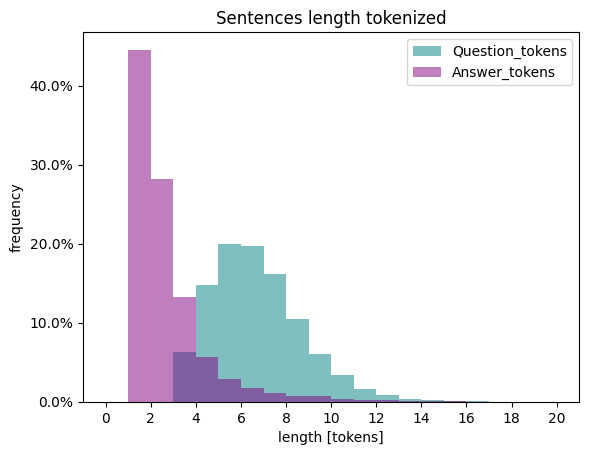

In [40]:
train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [41]:
train_df_final.shape

(14373, 4)

In [42]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.19
	         median: 6.00
	         minimum: 3
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 2.22
	         median: 2.00
	         minimum: 1
	         maximum: 17)


In [43]:
# keeping only the 95% of the data

cutoff = 95

In [44]:
# keeping only the 95% of the data

get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [45]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [46]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [47]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.01
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.96
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [48]:
train_df_final.shape

(13387, 4)

# Must make pairs from the dataset with removed short and long sequences

In [49]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [50]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [51]:
len(train_pairs_final), len(test_pairs_final)

(13387, 2114)

# building the model

In [52]:
from modules.models import Seq2Seq

In [53]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        #self.hidden = torch.zeros(1, 1, hidden_size)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        # The LSTM is our last cell because it produces the hidden state        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        #x = x.view(1, 1, -1)
        x = x.view(x.shape[0], 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.hidden_size, self.hidden_size)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

    
    

class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    def __init__(self, input_size, hidden_size, embedding_size, output_size):    
        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, teacher_forcing_ratio: float = 0.5):
        max_len, batch_size = trg_batch.shape
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        # last hidden & cell state of the encoder is used as the decoder's initial hidden state
        _, hidden, cell = self.encoder(src_batch, encoder_hidden, cell_state)
        
        trg = trg_batch[0]
        for i in range(1, max_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

In [54]:
hidden_size = 256

In [55]:
embedding_dim = 256

In [56]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words)

In [57]:
seq2seq = seq2seq.to(device)

In [58]:
from torch import optim
import torch.nn as nn

In [59]:
learning_rate = 0.001
num_epochs = 5

In [60]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device)

In [61]:
def train(model, pairs, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    
    total_loss = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    

    return total_loss / len(pairs)

In [62]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [5,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:650: indexSelectSmallIndex: block: [1,0,0], thread: [6,0,0] Asser

RuntimeError: CUDA error: CUBLAS_STATUS_INTERNAL_ERROR when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`